# ARIMA - Total Opens - 20180905

## To add a heading:
- Insert a new cell
- Type or paste-in content
- Place a single / just one "pound-sign" in front of the heading content
- Select "Markdown"
- Press "Shift", "Enter" at same time to convert to clean commentary

## To add a sub-heading:
- Insert a new cell
- Type or paste-in content
- Place two "pound-signs" in front of the sub-heading
- Select "Markdown"
- Press "Shift", "Enter" at same time to convert to clean commentary

## To add new bulleted documentation:

- Insert a new cell
- Type or paste-in content
- Place a "dash" character in front of the bulleted content
- Select "Markdown"
- Press "Shift", "Enter" at same time to convert to clean commentary

## References
- http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- http://people.duke.edu/~rnau/whatuse.htm
- http://people.duke.edu/~rnau/arimrule.htm

# Instantiate libraries

In [1]:
# connection to database
# must run "pip install pyodbc" from a command prompt first to download and install pyodbc module for python
import pyodbc
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pylab as plt
import matplotlib as mpl

%matplotlib inline

from datetime import datetime
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

## Connect to DB

In [2]:
# Connect via pyodbc to listed data sources on machine
print(pyodbc.dataSources())
print("Connecting via ODBC")

# set connection properties and query-string
conn = pyodbc.connect(dsn='EDW', autocommit=False)
print(conn)

print("Connected!\n")

# you can then use conn cursor to perform queries


{'dBASE Files': 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)', 'Excel Files': 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'MS Access Database': 'Microsoft Access Driver (*.mdb, *.accdb)', 'NZSQL': 'NetezzaSQL', 'EDW': 'Teradata', 'Sample Hortonworks Hive DSN': 'Hortonworks Hive ODBC Driver'}
Connecting via ODBC
Connected!



# Read Data - AirPassengers.csv dataset

In [3]:
# set query string and read the data
#SELECT CAMP_CD,CID_CUST_ID,VERSION_NAME,RNK_GRP,RNK,TEST_CELL,MODEL_1,MODEL_2
#,PROPENSITY, PROPENSITY_DTL,TILE_2_8_DTL,FINANCE_BANNER
#,TOTAL_OPENS,TOTAL_CLICKS
#,UNIQUE_OPENS,UNIQUE_CLICKS
#,TOT_UNITS,TOT_TRANS
#,TOT_REV,TOT_SVCS_REV
#,RESPONSE,SVCS_RESPONSE

# RESPONSE BY TREATMENT FLAG(MODEL VS NO-MODEL), VERSION(SECONDARY VS TERTIARY LOCATION), FINANCE BANNER (1,2,3,4)
#sql_getdata = "SELECT RESPONSE,1 as intercept,PROPENSITY,FINANCE_BANNER FROM PROD_CAM_SND_ANALYTICS..SLT_0817_ANALYSIS_FILE;"

# RESPONSE BY DETAILED SECONDARY / TERTIARY TILE DATA
#sql_getdata = "SELECT RESPONSE,1 as intercept,TILE_2_8_DTL,FINANCE_BANNER FROM PROD_CAM_SND_ANALYTICS..SLT_0817_ANALYSIS_FILE;"

# RESPONSE BY SECONDARY VERSUS TERTIARY VERSUS DOTD - TOP LEVEL COMPARISON

sql_totaldeploys = '''
SELECT "Date"
, Deployments FROM prodbbyciadhocwrk.a1000391_EM_TRANS
ORDER BY FISC_WK;
'''

sql_totalopens = '''
SELECT "Date"
, CASE WHEN "DATE" >= '2017-05-07' THEN 1 ELSE 0 END AS INFLECT
, CASE WHEN EXTRACT(MONTH FROM "DATE") IN (11,12,1) THEN 1 ELSE 0 END AS HOLIDAY
, CumOpens FROM prodbbyciadhocwrk.a1000391_EM_TRANS
ORDER BY FISC_WK;
'''

sql_totalopens_broadreach = '''
SELECT * FROM prodbbyciadhocwrk.a1000391_EM_TRANS
WHERE SUBSTRING(MAJOR_GROUP FROM 1 FOR 1) = '1'
ORDER BY FISC_WK;
'''

sql_totalopens_subscription = '''
SELECT * FROM prodbbyciadhocwrk.a1000391_EM_TRANS
WHERE SUBSTRING(MAJOR_GROUP FROM 1 FOR 1) = '2'
ORDER BY FISC_WK;
'''

sql_totalopens_triggered = '''
SELECT * FROM prodbbyciadhocwrk.a1000391_EM_TRANS
WHERE SUBSTRING(MAJOR_GROUP FROM 1 FOR 1) = '3'
ORDER BY FISC_WK;
'''

sql_totalopens_transactional = '''
SELECT * FROM prodbbyciadhocwrk.a1000391_EM_TRANS
WHERE SUBSTRING(MAJOR_GROUP FROM 1 FOR 1) = '4'
ORDER BY FISC_WK;
'''

sql_totalopens_other = '''
SELECT * FROM prodbbyciadhocwrk.a1000391_EM_TRANS
WHERE SUBSTRING(MAJOR_GROUP FROM 1 FOR 1) = '5'
ORDER BY FISC_WK;
'''

print(sql_totaldeploys)

data= pd.read_sql(sql_totaldeploys,conn)
print('\n Data Types:')
print(data.dtypes)



SELECT "Date"
, Deployments FROM prodbbyciadhocwrk.a1000391_EM_TRANS
ORDER BY FISC_WK;


 Data Types:
Date           object
Deployments     int64
dtype: object


In [4]:
print(data.head)

<bound method NDFrame.head of            Date  Deployments
0    2013-02-03          226
1    2013-02-10          141
2    2013-02-17          221
3    2013-02-24          257
4    2013-03-03          216
5    2013-03-10          263
6    2013-03-17          222
7    2013-03-24          157
8    2013-03-31          263
9    2013-04-07          168
10   2013-04-14          130
11   2013-04-21          222
12   2013-04-28          276
13   2013-05-05          274
14   2013-05-12          285
15   2013-05-19          258
16   2013-05-26          271
17   2013-06-02          303
18   2013-06-09          250
19   2013-06-16          296
20   2013-06-23          283
21   2013-06-30          303
22   2013-07-07          232
23   2013-07-14          181
24   2013-07-21          248
25   2013-07-28          304
26   2013-08-04          285
27   2013-08-11          306
28   2013-08-18          348
29   2013-08-25          339
..          ...          ...
267  2018-03-18          473
268  2018-03-

In [5]:
#data = pd.read_csv('C://Users//a1000391//Desktop//AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data["Date"] = pd.to_datetime(data["Date"])
data.set_index(['Date'])
print(data.head)
print('\n Data Types:')
print(data.dtypes)
print(data.index)

<bound method NDFrame.head of           Date  Deployments
0   2013-02-03          226
1   2013-02-10          141
2   2013-02-17          221
3   2013-02-24          257
4   2013-03-03          216
5   2013-03-10          263
6   2013-03-17          222
7   2013-03-24          157
8   2013-03-31          263
9   2013-04-07          168
10  2013-04-14          130
11  2013-04-21          222
12  2013-04-28          276
13  2013-05-05          274
14  2013-05-12          285
15  2013-05-19          258
16  2013-05-26          271
17  2013-06-02          303
18  2013-06-09          250
19  2013-06-16          296
20  2013-06-23          283
21  2013-06-30          303
22  2013-07-07          232
23  2013-07-14          181
24  2013-07-21          248
25  2013-07-28          304
26  2013-08-04          285
27  2013-08-11          306
28  2013-08-18          348
29  2013-08-25          339
..         ...          ...
267 2018-03-18          473
268 2018-03-25          536
269 2018-04-01    

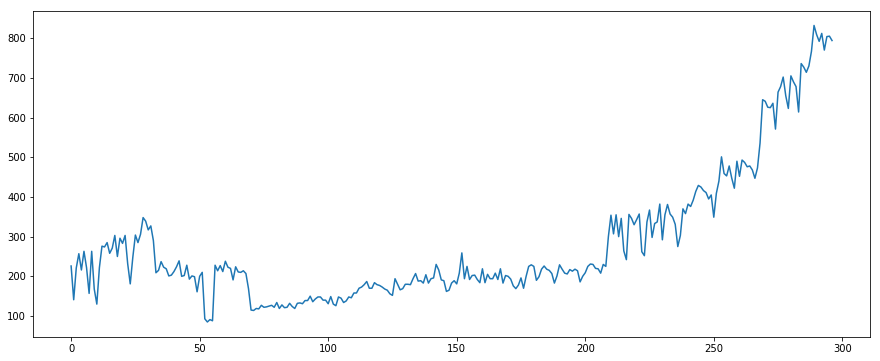

In [6]:
ts = data['Deployments']
ts.head(10)
plt.plot(ts)

## Tests for Stationarity - Various Techniques applied

## Stationarity Tests - Levels

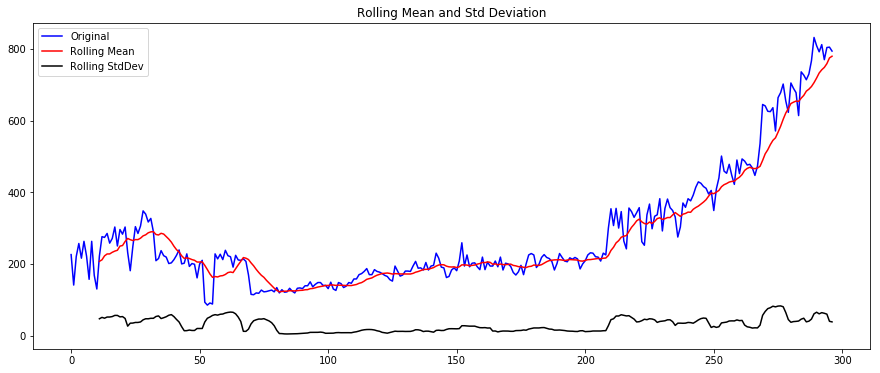

Results of Dickey-Fuller Test
Test Statistic                   2.324748
p-value                          0.998970
#Lags Used                       6.000000
Number of Observations Used    290.000000
Critical Value (1%)             -3.453102
Critical Value (5%)             -2.871559
Critical Value (10%)            -2.572108
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller
from pandas.core import datetools
#from pandas.tseries import datetools

def test_stationarity(timeseries):
    #determine rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
    #rolstd  = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12,center=False).std()
    
    #Plot Rolling Stats
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling StdDev')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Std Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller Test
    print('Results of Dickey-Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(data.Deployments)
    
    

## Stationarity Tests - First Difference

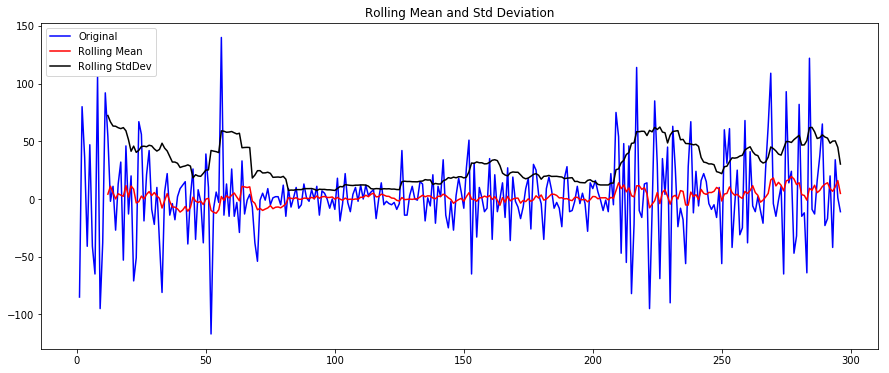

Results of Dickey-Fuller Test
Test Statistic                -9.418123e+00
p-value                        5.597250e-16
#Lags Used                     5.000000e+00
Number of Observations Used    2.900000e+02
Critical Value (1%)           -3.453102e+00
Critical Value (5%)           -2.871559e+00
Critical Value (10%)          -2.572108e+00
dtype: float64


In [9]:
data['first_difference'] = data.Deployments - data.Deployments.shift(1)
test_stationarity(data.first_difference.dropna(inplace=False))

## Stationarity Tests - Seasonal Differencing

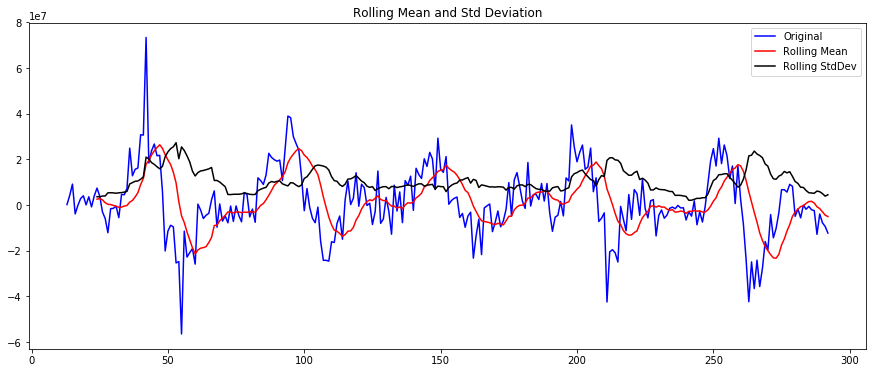

Results of Dickey-Fuller Test
Test Statistic                  -3.718189
p-value                          0.003864
#Lags Used                      14.000000
Number of Observations Used    265.000000
Critical Value (1%)             -3.455270
Critical Value (5%)             -2.872509
Critical Value (10%)            -2.572615
dtype: float64


In [17]:
data['seasonal_difference'] = data.CumOpens - data.CumOpens.shift(13)
test_stationarity(data.seasonal_difference.dropna(inplace=False))

## Stationarity Tests - Seasonal First Difference (first diff of seasonal difference)

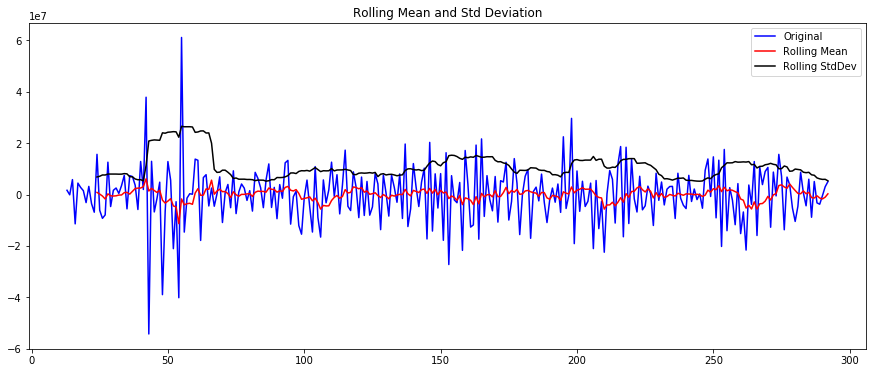

Results of Dickey-Fuller Test
Test Statistic                -7.767277e+00
p-value                        9.116921e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.640000e+02
Critical Value (1%)           -3.455365e+00
Critical Value (5%)           -2.872551e+00
Critical Value (10%)          -2.572638e+00
dtype: float64


In [12]:
data['seasonal_first_difference'] = data.first_difference - data.first_difference.shift(12)
test_stationarity(data.seasonal_first_difference.dropna(inplace=False))

## Stationarity Tests - Take Logs

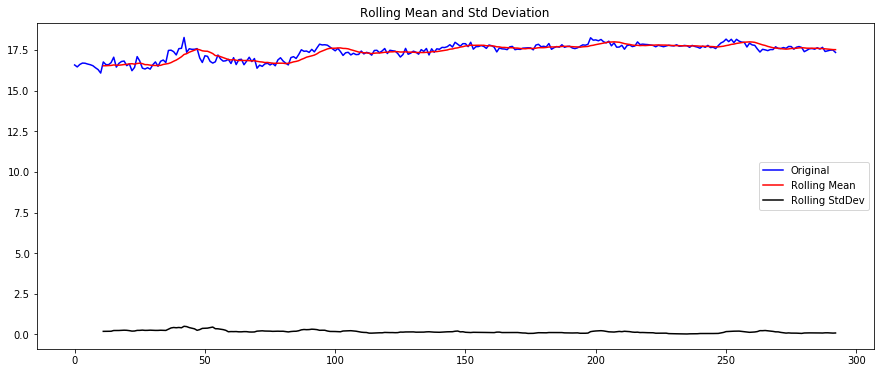

Results of Dickey-Fuller Test
Test Statistic                  -2.102829
p-value                          0.243379
#Lags Used                      16.000000
Number of Observations Used    276.000000
Critical Value (1%)             -3.454267
Critical Value (5%)             -2.872070
Critical Value (10%)            -2.572381
dtype: float64


In [17]:
data['logs'] = np.log(data.CumOpens)
test_stationarity(data.logs)

## Stationarity Tests - Moving Average

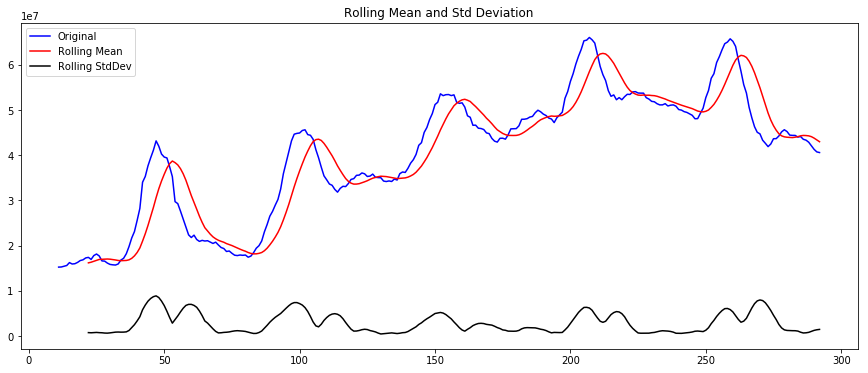

Results of Dickey-Fuller Test
Test Statistic                  -2.065664
p-value                          0.258543
#Lags Used                      14.000000
Number of Observations Used    267.000000
Critical Value (1%)             -3.455081
Critical Value (5%)             -2.872427
Critical Value (10%)            -2.572571
dtype: float64


In [18]:
data['moving_avg'] = data.CumOpens.rolling(window=12,center=False).mean()
test_stationarity(data.moving_avg.dropna(inplace=False))

## Stationarity Tests - Moving Average of Logs

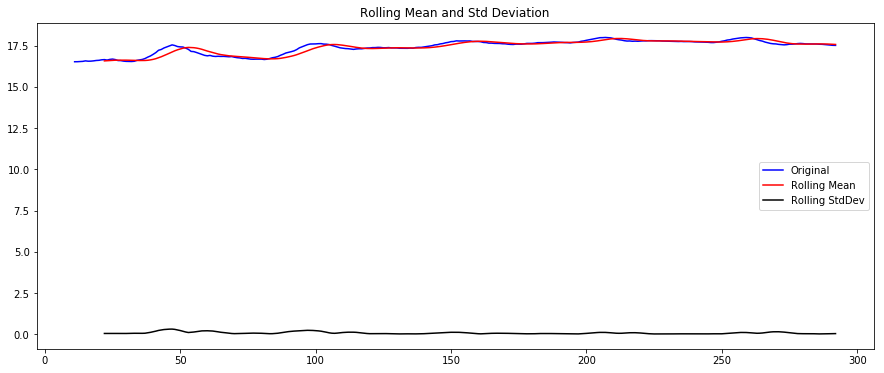

Results of Dickey-Fuller Test
Test Statistic                  -2.144023
p-value                          0.227185
#Lags Used                      13.000000
Number of Observations Used    268.000000
Critical Value (1%)             -3.454988
Critical Value (5%)             -2.872386
Critical Value (10%)            -2.572549
dtype: float64


In [19]:
data['log_moving_avg'] = data.logs.rolling(window=12,center=False).mean()
test_stationarity(data.log_moving_avg.dropna(inplace=False))

## Take log-difference and retest stationarity

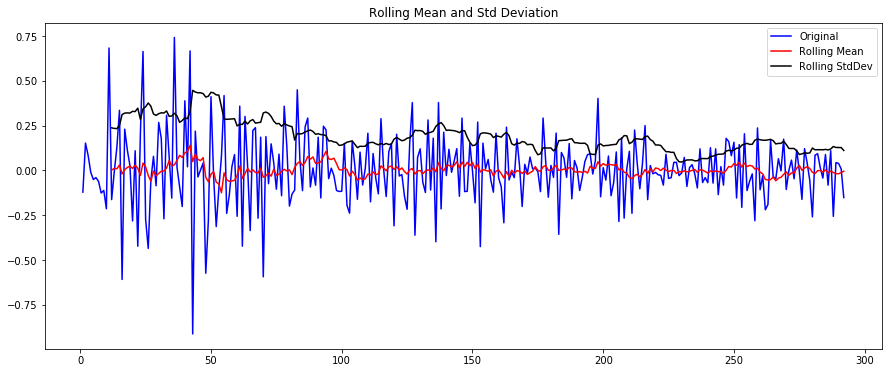

Results of Dickey-Fuller Test
Test Statistic                -6.351875e+00
p-value                        2.598876e-08
#Lags Used                     1.500000e+01
Number of Observations Used    2.760000e+02
Critical Value (1%)           -3.454267e+00
Critical Value (5%)           -2.872070e+00
Critical Value (10%)          -2.572381e+00
dtype: float64


In [20]:
data['log_moving_avg_diff'] = data.logs - data.logs.shift(1)
test_stationarity(data.log_moving_avg_diff.dropna(inplace=False))

## Stationarity Test - Exponential Weighted Avg

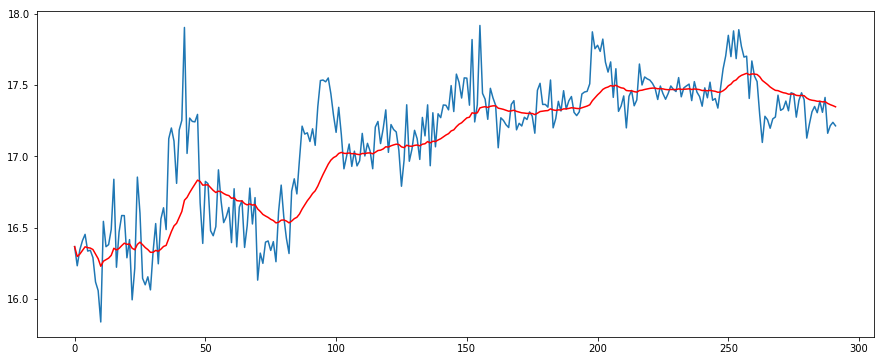

In [12]:
expweighted_avg = ts_log.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

## Stationarity Test - Log Exponential Weighted Avg

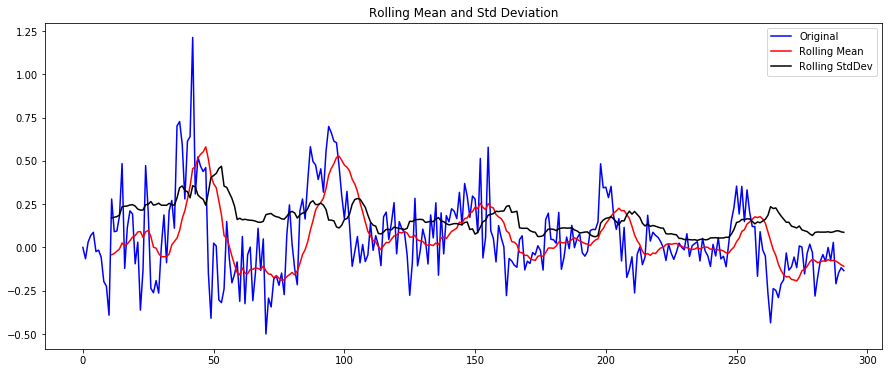

Results of Dickey-Fuller Test
Test Statistic                  -4.814677
p-value                          0.000051
#Lags Used                       6.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [13]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)

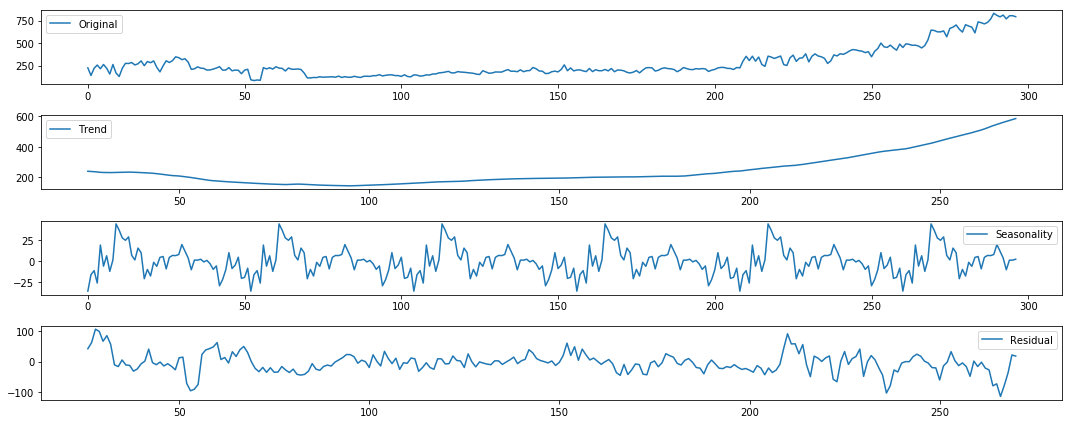

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
# specify freq=52 to represent 52 weeks of an annual seasonal cycle
decomposition = seasonal_decompose(ts, model='additive', freq=52)
#decomposition = seasonal_decompose(ts, model='multiplicative', freq=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

## Identification - Plot ACF / PACF - Using First Difference found to be stationary

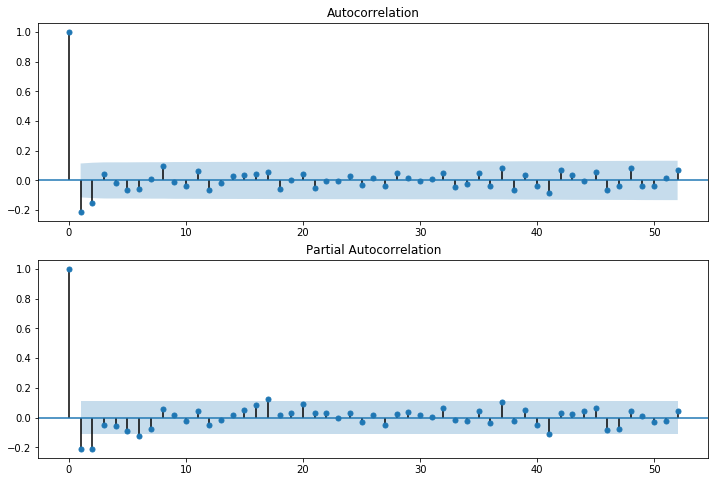

In [13]:
# Note: You must take data from 2nd-observation-on because we took first-difference in the original definition
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.first_difference.iloc[2:], lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.first_difference.iloc[2:], lags=52, ax=ax2)


## Identification - Plot ACF / PACF - Assume we used a seasonal differenced var

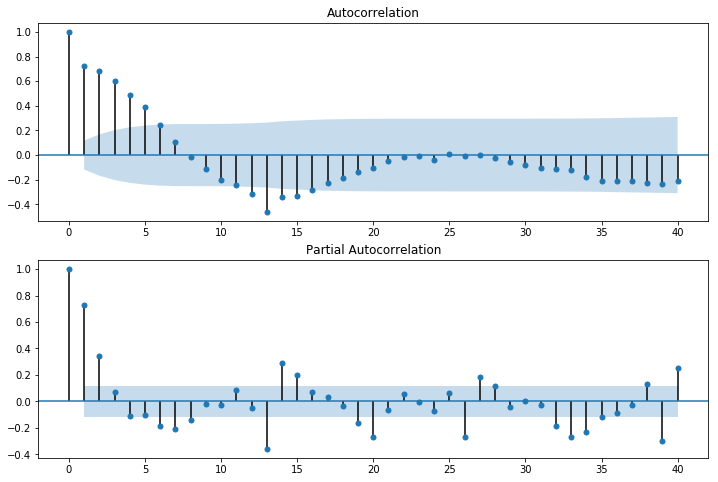

In [19]:
# Note: You must take data from 13th-observation-on because we took 12 lags in the original definition
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.seasonal_difference.iloc[14:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.seasonal_difference.iloc[14:], lags=40, ax=ax2)


In [14]:
from statsmodels.tsa.arima_model import ARIMA

                             ARIMA Model Results                              
Dep. Variable:          D.Deployments   No. Observations:                  296
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1455.759
Method:                       css-mle   S.D. of innovations             33.079
Date:                Mon, 15 Oct 2018   AIC                           2919.518
Time:                        16:09:20   BIC                           2934.280
Sample:                             1   HQIC                          2925.429
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9926      1.284      1.552      0.122      -0.524       4.510
ar.L1.D.Deployments    -0.2758      0.057     -4.835      0.000      -0.388      -0.164
ar.L2.D.Deployme

C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1026: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1029: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1035: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

Text(0.5,1,'RSS: 324808.5778')

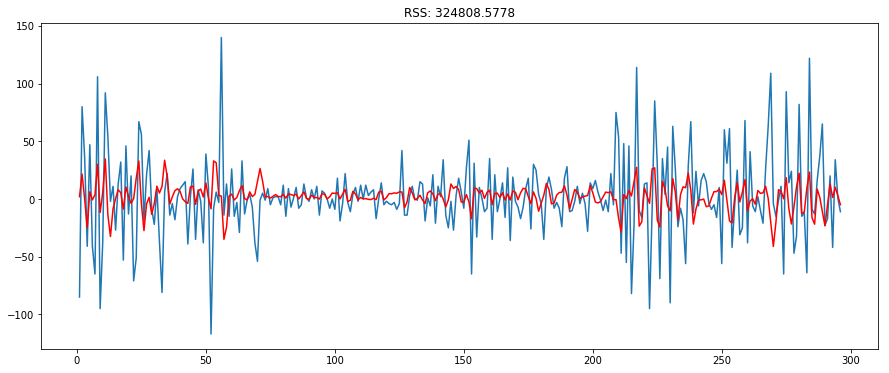

In [17]:
#AR Model
model = ARIMA(data.Deployments, order=(2,1,0))
results_AR = model.fit(disp=-1)
print(results_AR.summary())
plt.plot(data.first_difference)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data.first_difference.dropna(inplace=False))**2))


                             ARIMA Model Results                              
Dep. Variable:          D.Deployments   No. Observations:                  296
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1453.658
Method:                       css-mle   S.D. of innovations             32.841
Date:                Mon, 15 Oct 2018   AIC                           2915.316
Time:                        16:10:23   BIC                           2930.078
Sample:                             1   HQIC                          2921.226
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9832      0.964      2.056      0.041       0.093       3.874
ma.L1.D.Deployments    -0.3018      0.058     -5.207      0.000      -0.415      -0.188
ma.L2.D.Deployme

Text(0.5,1,'RSS: 320404.0683')

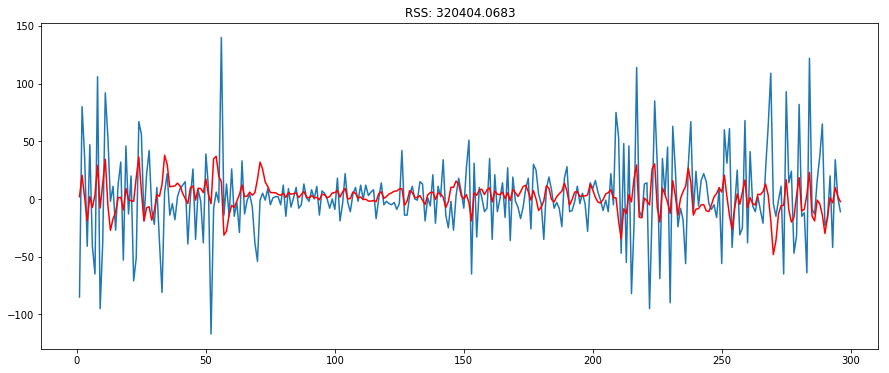

In [20]:
#MA Model
model = ARIMA(data.Deployments, order=(0,1,2))
results_MA = model.fit(disp=-1)
print(results_MA.summary())
plt.plot(data.first_difference)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-data.first_difference.dropna(inplace=False))**2))


## Build the Model - Basic ARIMA

                             ARIMA Model Results                              
Dep. Variable:          D.Deployments   No. Observations:                  296
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1453.378
Method:                       css-mle   S.D. of innovations             32.810
Date:                Mon, 15 Oct 2018   AIC                           2918.757
Time:                        16:10:52   BIC                           2940.899
Sample:                             1   HQIC                          2927.622
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9836      0.930      2.132      0.034       0.160       3.807
ar.L1.D.Deployments    -0.2268      0.366     -0.619      0.536      -0.944       0.491
ar.L2.D.Deployme

Text(0.5,1,'RSS: 319783.3189')

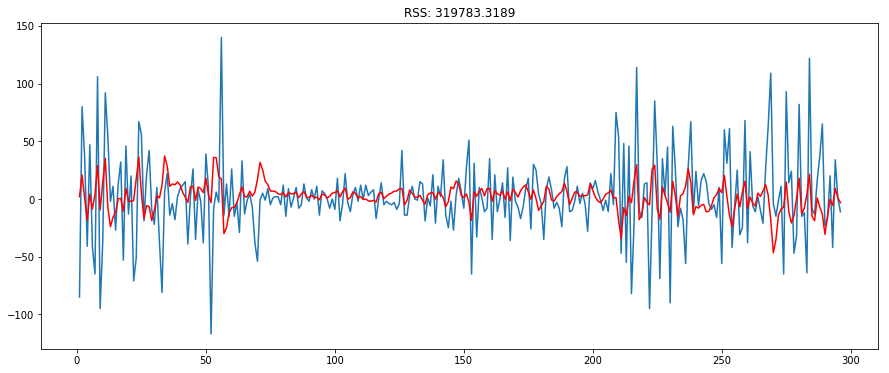

In [22]:
#Combined Model
model = ARIMA(data.Deployments, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())
plt.plot(data.first_difference)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-data.first_difference.dropna(inplace=False))**2))


## Build the Model - What about exogenous vars?

                             ARIMA Model Results                              
Dep. Variable:             D.CumOpens   No. Observations:                  292
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5003.538
Method:                       css-mle   S.D. of innovations        6685988.505
Date:                Tue, 18 Sep 2018   AIC                          10023.076
Time:                        07:46:32   BIC                          10052.491
Sample:                             1   HQIC                         10034.859
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.722e+05   2.79e+05      0.616      0.538   -3.75e+05     7.2e+05
INFLECT          -4.512e+05   5.68e+05     -0.794      0.428   -1.57e+06    6.63e+05
ar.L1.D.CumOpens    -0.1872 

Text(0.5,1,'RSS: 13080564139751108.0000')

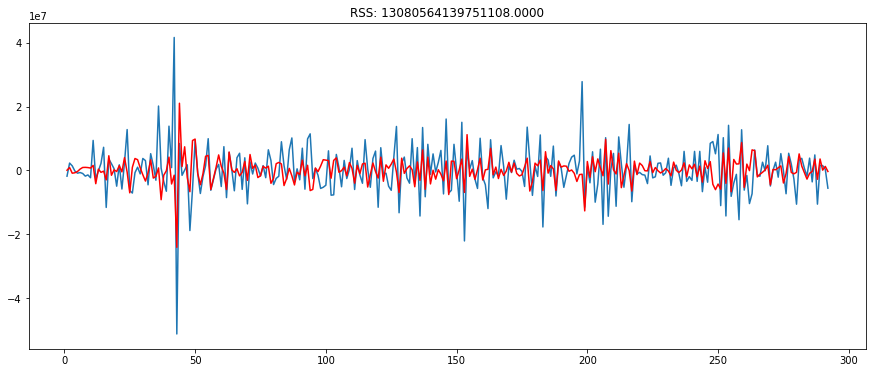

In [25]:
#Combined Model
#exogx = data[["HOLIDAY","INFLECT"]]
exogx = data[["INFLECT"]]

model = ARIMA(data.CumOpens, order=(3,1,2), exog=exogx )
results2=model.fit()
print(results2.summary())
plt.plot(data.first_difference)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-data.first_difference.dropna(inplace=False))**2))


## Build the Model - What about Seasonal Moving Average?

- Here we started with our basic ARIMA(3,1,2) and added 52 week seasonality
- We removed insignificant lags to reach the specification seen below.

                                 Statespace Model Results                                 
Dep. Variable:                        Deployments   No. Observations:                  297
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 52)   Log Likelihood               -1237.498
Date:                            Mon, 15 Oct 2018   AIC                           2482.995
Time:                                    16:35:27   BIC                           2496.984
Sample:                                         0   HQIC                          2488.629
                                            - 297                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2751      0.055     -4.977      0.000      -0.383      -0.167
ar.L2         -0.2155      0.054   

Text(0.5,1,'RSS: 574294.2513')

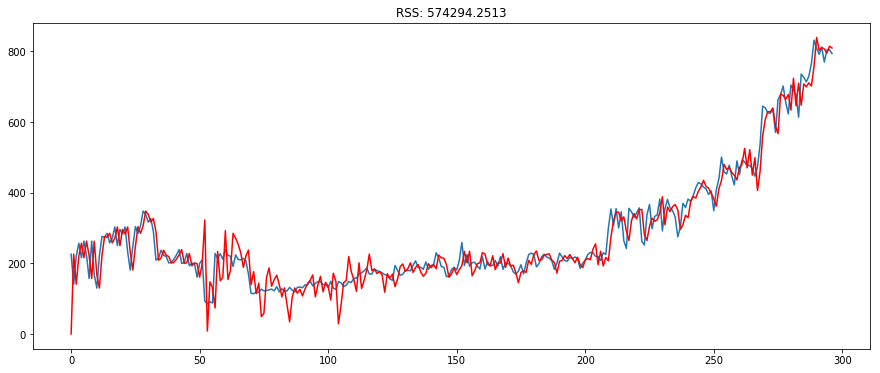

In [36]:
model = sm.tsa.statespace.SARIMAX(data.Deployments, trend='n', order=(2,1,0), seasonal_order=(0,1,1,52))
results_sarimax = model.fit()
print(results_sarimax.summary())
plt.plot(data.Deployments)
plt.plot(results_sarimax.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_sarimax.fittedvalues-data.Deployments.dropna(inplace=False))**2))


## Build Forecast - In-Sample Check

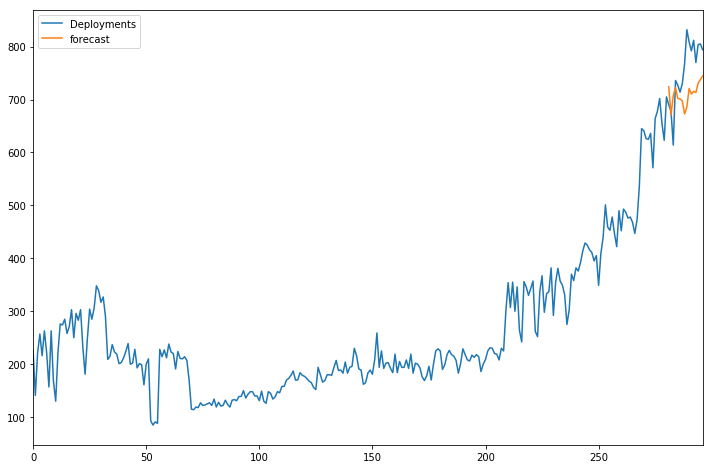

In [37]:
data['forecast'] = results_sarimax.predict(start = 281, end = 297, dynamic = True)
data[['Deployments','forecast']].plot(figsize=(12,8))

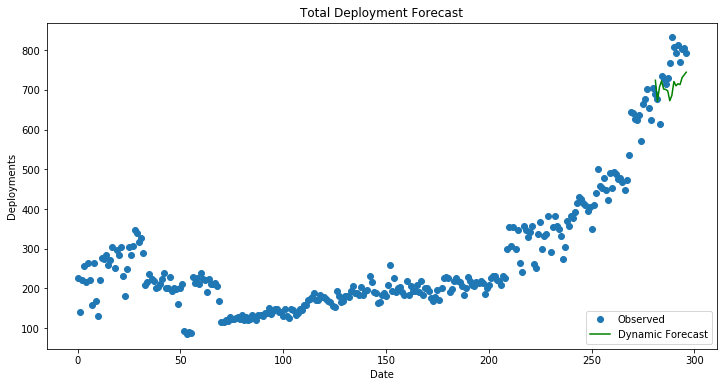

In [38]:
npredict = data.shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Total Deployment Forecast', xlabel='Date', ylabel='Deployments')
ax.plot(data.index[-npredict-npre+1:], data.ix[-npredict-npre+1:, 'Deployments'], 'o', label='Observed')
ax.plot(data.index[-npredict-npre+1:], data.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic Forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')


# Build Forecast - Out-of-sample forecast

In [39]:
from dateutil.relativedelta import relativedelta  
start = data.shape[0]
start_date = datetime.strptime("2018-10-14", "%Y-%m-%d")
data_list = [start + x for x in range(0,16)]
#data_list = [start + x for x in range(0,16)], [start_date + relativedelta(weeks=y) for y in range(0,16)]
#print(data_list)
future = pd.DataFrame(index=data_list, columns=data.columns)
data2 = pd.concat([data, future])


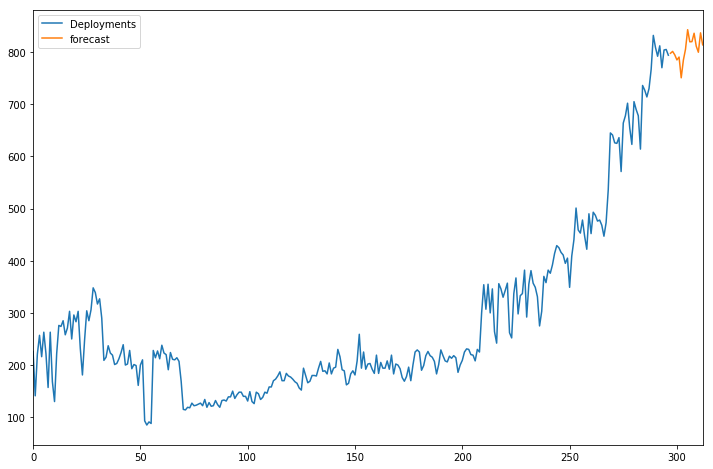

In [42]:
data2['forecast'] = results_sarimax.predict(start = 297, end=318, dynamic=True)
data2[['Deployments','forecast']].ix[-24:].plot(figsize=(12,8))

In [43]:
print(data2)

          Date  Deployments  first_difference    forecast
0   2013-02-03        226.0               NaN         NaN
1   2013-02-10        141.0             -85.0         NaN
2   2013-02-17        221.0              80.0         NaN
3   2013-02-24        257.0              36.0         NaN
4   2013-03-03        216.0             -41.0         NaN
5   2013-03-10        263.0              47.0         NaN
6   2013-03-17        222.0             -41.0         NaN
7   2013-03-24        157.0             -65.0         NaN
8   2013-03-31        263.0             106.0         NaN
9   2013-04-07        168.0             -95.0         NaN
10  2013-04-14        130.0             -38.0         NaN
11  2013-04-21        222.0              92.0         NaN
12  2013-04-28        276.0              54.0         NaN
13  2013-05-05        274.0              -2.0         NaN
14  2013-05-12        285.0              11.0         NaN
15  2013-05-19        258.0             -27.0         NaN
16  2013-05-26

In [44]:
from dateutil.relativedelta import relativedelta  
start = data.shape[0]
print("Forecast start row:", start)
start_date = max(data.Date) + relativedelta(weeks=1)
print("Forecast start date:", start_date)
#start_date = datetime.strptime("2018-09-16", "%Y-%m-%d")
data_list = [start + x for x in range(0,16)]
date_list = [start_date + relativedelta(weeks=y) for y in range(0,16)]
future = pd.DataFrame(index=data_list, columns=data.columns)
future2 = pd.DataFrame(date_list,index=data_list).rename(columns={0:'Date'})
future3 = pd.concat([future2,data.iloc[start:,1:]], axis=1)
#print(future3)
data2 = data.append(future3)
print(data2)

Forecast start row: 297
Forecast start date: 2018-10-14 00:00:00
          Date  Deployments  first_difference    forecast
0   2013-02-03        226.0               NaN         NaN
1   2013-02-10        141.0             -85.0         NaN
2   2013-02-17        221.0              80.0         NaN
3   2013-02-24        257.0              36.0         NaN
4   2013-03-03        216.0             -41.0         NaN
5   2013-03-10        263.0              47.0         NaN
6   2013-03-17        222.0             -41.0         NaN
7   2013-03-24        157.0             -65.0         NaN
8   2013-03-31        263.0             106.0         NaN
9   2013-04-07        168.0             -95.0         NaN
10  2013-04-14        130.0             -38.0         NaN
11  2013-04-21        222.0              92.0         NaN
12  2013-04-28        276.0              54.0         NaN
13  2013-05-05        274.0              -2.0         NaN
14  2013-05-12        285.0              11.0         NaN
15  201

           RunDate       Date       Metric    forecast
RowNbr                                                
297     2018-10-15 2018-10-14  Deployments  797.703119
298     2018-10-15 2018-10-21  Deployments  801.295684
299     2018-10-15 2018-10-28  Deployments  794.648899
300     2018-10-15 2018-11-04  Deployments  784.951903
301     2018-10-15 2018-11-11  Deployments  790.491725
302     2018-10-15 2018-11-18  Deployments  750.671515
303     2018-10-15 2018-11-25  Deployments  784.450312
304     2018-10-15 2018-12-02  Deployments  805.461926
305     2018-10-15 2018-12-09  Deployments  842.939943
306     2018-10-15 2018-12-16  Deployments  819.690908
307     2018-10-15 2018-12-23  Deployments  820.002256
308     2018-10-15 2018-12-30  Deployments  836.133768
309     2018-10-15 2019-01-06  Deployments  811.311453
310     2018-10-15 2019-01-13  Deployments  799.688139
311     2018-10-15 2019-01-20  Deployments  836.884430
312     2018-10-15 2019-01-27  Deployments  813.866914


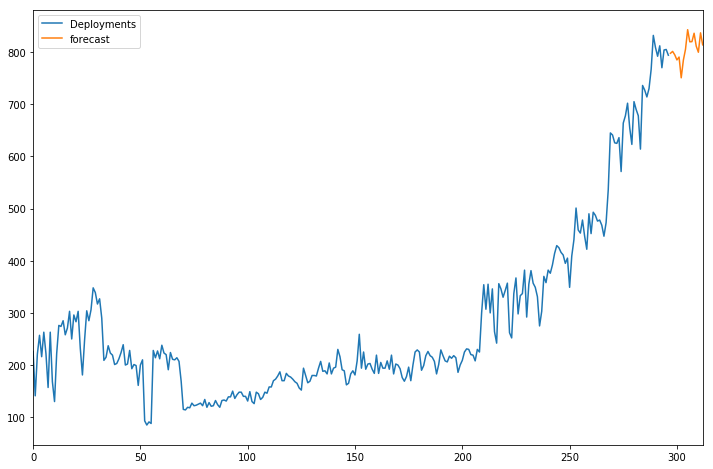

In [46]:
data2['forecast'] = results_sarimax.predict(start = start, end=start+16, dynamic=True)
data2[['Deployments','forecast']].ix[-24:].plot(figsize=(12,8))
data2['Metric'] = 'Deployments'
data2['RunDate'] = datetime.now().date()
data3 = data2[['RunDate','Date','Metric','forecast']].iloc[start:,:]
data3.index.rename('RowNbr',inplace=True)
print(data3)

In [47]:
data3.to_csv('c://users//a1000391//desktop//Deployments.csv', sep=',', encoding='utf-8')

#Tab-delimited
#data3.to_csv('c://users//a1000391//desktop//CumOpens.csv', sep='/t', encoding='utf-8')